# Project B


This notebook will an exploratory data analysis of the chosen dataset.

## Packages Needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce

from bokeh.plotting import figure
from bokeh.io import show, output_notebook, curdoc, output_file
from bokeh.models import ColumnDataSource, FactorRange, Legend, HoverTool, GeoJSONDataSource, \
                        LinearColorMapper, ColorBar, NumeralTickFormatter, Div, Select, TableColumn, \
                        DataTable, CheckboxGroup, Tabs, Panel, CheckboxButtonGroup, RadioButtonGroup
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application
from bokeh.palettes import Category20c, Pastel1, Set3, Blues
from bokeh.layouts import column, row, WidgetBox, gridplot
from bokeh.embed import file_html
from bokeh.resources import CDN
from bokeh.tile_providers import get_provider, Vendors
from bokeh.transform import linear_cmap,factor_cmap

output_notebook()

Loading BokehJS ...

In [2]:
path = 'C:\\Users\\Miche\\OneDrive - Danmarks Tekniske Universitet\\MMC\\2. Semester\\Social Data\\websites'
os.chdir(path)
os.getcwd()

'C:\\Users\\Miche\\OneDrive - Danmarks Tekniske Universitet\\MMC\\2. Semester\\Social Data\\websites'

## Load Data Business Dataset + Prep

In [3]:
df_2014 = pd.read_csv('data/yelp_reviews_RV_categories_2014.csv')
df_2015 = pd.read_csv('data/yelp_reviews_RV_categories_2015.csv')
df_2016 = pd.read_csv('data/yelp_reviews_RV_categories_2016.csv')
df_2017 = pd.read_csv('data/yelp_reviews_RV_categories_2017.csv')
df_2018 = pd.read_csv('data/yelp_reviews_RV_categories_2018.csv')
df_2019 = pd.read_csv('Restaurant-Guide/data/yelp_reviews_RV_categories_2019.csv')
df_2020 = pd.read_csv('Restaurant-Guide/data/yelp_reviews_RV_categories_2020.csv')

df = df_2014.append([df_2015, df_2016, df_2017, df_2018, df_2019, df_2020])
df = df.drop(['hours','address', 'username'],axis=1) #these coulmns are removed, since they are not used. 

In [4]:
print('Column names:', df.columns)
print('Any missing values:', df.isnull().sum().sum())

Column names: Index(['business_id', 'name', 'city', 'state', 'postal_code', 'latitude',
       'longitude', 'stars', 'review_count', 'attributes', 'categories',
       'cat_kitchen', 'cat_type', 'state_name', 'latitude_state',
       'longitude_state', 'PriceRange', 'AvgPrice', 'user_id', 'review_stars',
       'text', 'date', 'user_count', 'average_stars'],
      dtype='object')
Any missing values: 0


No further data prep is needed, since it is already done.

## Testing top categories

In [5]:
print(len(df['cat_kitchen'].value_counts()))

16


In [6]:
df['cat_kitchen'].value_counts()

American (New)            1532422
American (Traditional)    1509972
Italian                    535252
Mexican                    378967
Japanese                   317757
Mediterranean              135315
Latin American             126121
Chinese                    119064
Thai                       116807
Vietnamese                  87961
Indian                      72209
Greek                       62608
Caribbean                   55091
Korean                      55008
Cajun/Creole                51139
New Mexican Cuisine         21629
Name: cat_kitchen, dtype: int64

## Basic statistics

In [7]:
variables = ['name','city','state','categories','cat_kitchen','cat_type','PriceRange']
round(df[variables].describe(),2)

,name,city,state,categories,cat_kitchen,cat_type,PriceRange
count,5177322,5177322,5177322,5177322,5177322,5177322,5177322
unique,8688,306,11,9652,16,17,5
top,Yard House,Austin,MA,"Tapas Bars, Restaurants, American (New), Food,...",American (New),Nightlife,$$
freq,53970,741987,1211590,42825,1532422,997131,3958483


In [8]:
variables = ['stars', 'AvgPrice']
round(df[variables].describe(),2)

,stars,AvgPrice
count,5177322.00,5177322.00
mean,3.80,19.56
std,0.56,11.28
min,1.00,0.00
25%,3.50,20.00
50%,4.00,20.00
75%,4.00,20.00
max,5.00,75.00


C:\Users\Miche\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


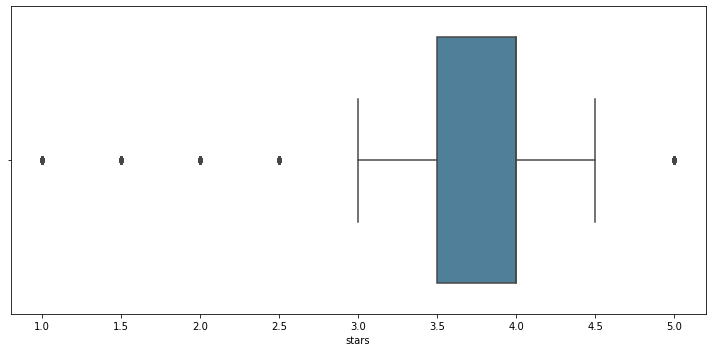

In [9]:
fig = plt.figure(figsize=(10, 5))
sns.boxplot(df['stars'], color='#2b8cbe', saturation=0.5)
plt.tight_layout(h_pad=2)

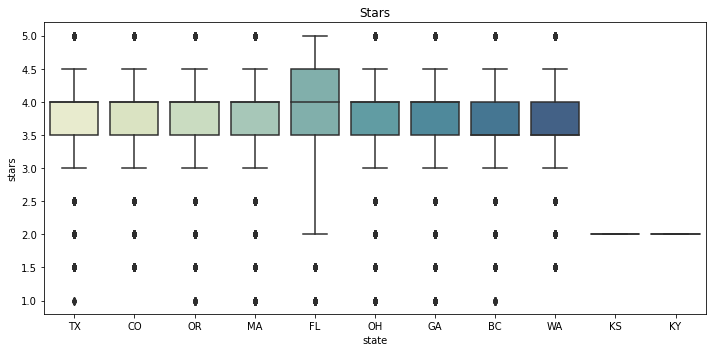

In [10]:
fig = plt.figure(figsize=(10,5))
selected = ['stars']
plt.title('Stars')
sns.boxplot(x='state', y='stars', data=df, palette='YlGnBu', saturation=0.5)
plt.tight_layout(h_pad=2)

## Plots for the Overview page

### General plots

In [11]:
restaurants = df.drop_duplicates(subset=['name','state'])
restaurant_ = restaurants.groupby(['state_name', 'latitude_state', 'longitude_state']).size().reset_index(name='Counts').sort_values(by='Counts',ascending=False)
restaurants.shape

(9135, 24)

Below it used to define the sizes of the circle on our world map. The function is forcing the count values to be between 15 and 50. This is done, because in some states there are above 1000 of restaurants, hence why the circle will fill the whole plot without seeing the map. 

In [12]:
r_max = max(restaurant_['Counts'])
r_min = min(restaurant_['Counts'])
t_min = 15
t_max = 50

restaurant_['Size'] = (restaurant_['Counts'] - r_min)/(r_max - r_min) * (t_max - t_min) + t_min

Map over the different states, where we have restaurants

In [13]:
# Define function to switch from lat/long to mercator coordinates
def x_coord(x, y):
    
    lat = x
    lon = y
    
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale
    return (x, y)
# Define coord as tuple (lat,long)
restaurants_copy = restaurant_.copy()
restaurants_copy['coordinates'] = list(zip(restaurants_copy['latitude_state'], restaurants_copy['longitude_state']))
# Obtain list of mercator coordinates
mercators = [x_coord(x, y) for x, y in restaurants_copy['coordinates']]

In [14]:
# Create mercator column in our df
restaurants_copy['mercator'] = mercators
# Split that column out into two separate columns - mercator_x and mercator_y
restaurants_copy[['mercator_x', 'mercator_y']] = restaurants_copy['mercator'].apply(pd.Series)

In [48]:
# Select tile set to use
chosentile = get_provider(Vendors.CARTODBPOSITRON)

tooltips = [("State","@state_name"), ("Count", "@Counts")]

counts = restaurants_copy['Counts'].to_list()

p = figure(title = 'Number of restaurants in North America', 
           x_axis_type="mercator", y_axis_type="mercator", 
           x_axis_label = 'Longitude', y_axis_label = 'Latitude', 
           tooltips = tooltips, plot_width=700, plot_height=600)

p.add_tile(chosentile)

p.circle(x = 'mercator_x', y = 'mercator_y', color = 'lightblue', source=restaurants_copy, 
         size='Size', fill_alpha = 0.7)
show(p)

In [49]:
html = file_html(p, CDN, "test")
print(html)





<!DOCTYPE html>
<html lang="en">
  
  <head>
    
      <meta charset="utf-8">
      <title>test</title>
      
      
        
          
        
        
          
        <script type="text/javascript" src="https://cdn.bokeh.org/bokeh/release/bokeh-2.3.1.min.js" integrity="sha384-YF85VygJKMVnHE+lLv2AM93Vbstr0yo2TbIu5v8se5Rq3UQAUmcuh4aaJwNlpKwa" crossorigin="anonymous"></script>
        <script type="text/javascript">
            Bokeh.set_log_level("info");
        </script>
        
      
      
    
  </head>
  
  
  <body>
    
      
        
          
          
            
              <div class="bk-root" id="b30c06d5-eba7-4a79-bc74-2c3305147fd5" data-root-id="6146"></div>
            
          
        
      
      
        <script type="application/json" id="6565">
          {"e058a4f6-9b11-455f-b359-6bfc89748bb1":{"defs":[],"roots":{"references":[{"attributes":{"below":[{"id":"6157"}],"center":[{"id":"6164"},{"id":"6172"}],"left":[{"id":"6165"}],"renderers":[{"

#### General Overview Plots

In [50]:
group_state_ = restaurants.groupby(['cat_kitchen']).size().reset_index(name='Counts')
group_state_['Type'] = group_state_['cat_kitchen'].astype(str)
df_dict_ = group_state_.to_dict('list')

group_state__ = restaurants.groupby(['cat_type']).size().reset_index(name='Counts')
group_state__['Type'] = group_state__['cat_type'].astype(str)
df_dict__ = group_state__.to_dict('list')

group_state = restaurants.groupby(['state_name']).size().reset_index(name='Counts')
group_state['state'] = group_state['state_name'].astype(str)
df_dict = group_state.to_dict('list')

In [56]:
title = 'Count of restaurants by state'
xlabel = 'State'
range_x = group_state.state.unique().tolist()

plot1 = figure(x_range=FactorRange(factors=range_x), y_range=(0,2500), plot_width=800, plot_height=500,
               x_axis_label=xlabel, toolbar_location=None, title=title)
plot1.vbar(x='state_name', width=0.7, bottom=0,
           top='Counts', source=df_dict, color='lightblue')

# hover tool
plot1.add_tools(HoverTool(tooltips=[('Count', "@Counts{1}")]))

# axis ticks
plot1.xaxis.major_tick_line_color = None 
plot1.xaxis.minor_tick_line_color = None 
plot1.yaxis.major_tick_line_color = None  
plot1.yaxis.minor_tick_line_color = None  
plot1.title.text_font_size = '13pt'
plot1.xaxis.major_label_orientation = "vertical"
plot1.title.align = 'center'

show(plot1)

In [57]:
title = 'Count of restaurants by kitchen'
range_x = group_state_['cat_kitchen'].unique().tolist()
xlabel = 'Kitchen type'

plot2 = figure(x_range=FactorRange(factors=range_x),y_range=(0,2500),  plot_width=800, plot_height=500,
               x_axis_label=xlabel, toolbar_location=None, title=title)
plot2.vbar(x='Type', width=0.7, bottom=0,
           top='Counts', source=df_dict_, color='lightblue')

# hover tool
plot2.add_tools(HoverTool(tooltips=[('Count', "@Counts")]))

# axis ticks
plot2.xaxis.major_tick_line_color = None 
plot2.xaxis.minor_tick_line_color = None 
plot2.yaxis.major_tick_line_color = None  
plot2.yaxis.minor_tick_line_color = None  
plot2.xaxis.major_label_orientation = "vertical"
plot2.title.text_font_size = '13pt'
plot2.title.align = 'center'

show(plot2)

In [58]:
title = 'Count of restaurants by type'
range_x = group_state__['cat_type'].unique().tolist()
xlabel = 'Types'

plot3 = figure(x_range=FactorRange(factors=range_x), y_range=(0,2500), plot_width=600, plot_height=500,
               x_axis_label=xlabel, toolbar_location=None, title=title)
plot3.vbar(x='Type', width=0.7, bottom=0,
           top='Counts', source=df_dict__, color='lightblue')

# hover tool
plot3.add_tools(HoverTool(tooltips=[('Count', "@Counts")]))

# axis ticks
plot3.xaxis.major_tick_line_color = None 
plot3.xaxis.minor_tick_line_color = None 
plot3.yaxis.major_tick_line_color = None  
plot3.yaxis.minor_tick_line_color = None  
plot3.xaxis.major_label_orientation = "vertical"
plot3.title.text_font_size = '13pt'
plot3.title.align = 'center'

show(plot3)

In [59]:
# Increase the plot widths
plot1.plot_width = plot2.plot_width = plot3.plot_width = 700
plot1.plot_height = plot2.plot_height = plot3.plot_height = 500


# Create three panels, one for each conference
state_panel = Panel(child=plot1, title='Count of restaurants by State')
kitchen_panel = Panel(child=plot2, title='Count of restaurants by Kitchen')
types_panel = Panel(child=plot3, title='Count of restaurants by Type')

# Assign the panels to Tabs
tabs = Tabs(tabs=[state_panel, kitchen_panel, types_panel])

# Show the tabbed layout
show(tabs)

In [60]:
html = file_html(tabs, CDN, "test")
print(html)





<!DOCTYPE html>
<html lang="en">
  
  <head>
    
      <meta charset="utf-8">
      <title>test</title>
      
      
        
          
        
        
          
        <script type="text/javascript" src="https://cdn.bokeh.org/bokeh/release/bokeh-2.3.1.min.js" integrity="sha384-YF85VygJKMVnHE+lLv2AM93Vbstr0yo2TbIu5v8se5Rq3UQAUmcuh4aaJwNlpKwa" crossorigin="anonymous"></script>
        <script type="text/javascript">
            Bokeh.set_log_level("info");
        </script>
        
      
      
    
  </head>
  
  
  <body>
    
      
        
          
          
            
              <div class="bk-root" id="65e769ab-f3c9-483b-a8fd-d5f453cb2a02" data-root-id="9490"></div>
            
          
        
      
      
        <script type="application/json" id="10279">
          {"cafc850d-ad2b-49f4-b219-edd0ddb52396":{"defs":[],"roots":{"references":[{"attributes":{"tabs":[{"id":"9487"},{"id":"9488"},{"id":"9489"}]},"id":"9490","type":"Tabs"},{"attributes":{"facto

In [61]:
group_state_ = df.groupby(['cat_kitchen']).size().reset_index(name='Counts')
group_state_['Type'] = group_state_['cat_kitchen'].astype(str)
df_dict_ = group_state_.to_dict('list')

group_state__ = df.groupby(['cat_type']).size().reset_index(name='Counts')
group_state__['Type'] = group_state__['cat_type'].astype(str)
df_dict__ = group_state__.to_dict('list')

group_state = df.groupby(['state_name']).size().reset_index(name='Counts')
group_state['state'] = group_state['state_name'].astype(str)
df_dict = group_state.to_dict('list')

In [62]:
title = 'Count of reviews by state'
xlabel = 'State'
range_x = group_state.state.unique().tolist()

plot1 = figure(x_range=FactorRange(factors=range_x), y_range=(0,1300000), plot_width=800, plot_height=500,
               x_axis_label=xlabel, toolbar_location=None, title=title)
plot1.vbar(x='state_name', width=0.7, bottom=0,
           top='Counts', source=df_dict, color='lightblue')

# hover tool
plot1.add_tools(HoverTool(tooltips=[('Count', "@Counts{1}")]))

# axis ticks
plot1.xaxis.major_tick_line_color = None 
plot1.xaxis.minor_tick_line_color = None 
plot1.yaxis.major_tick_line_color = None  
plot1.yaxis.minor_tick_line_color = None  
plot1.xaxis.major_label_orientation = "vertical"
plot1.title.text_font_size = '13pt'
plot1.title.align = 'center'

show(plot1)

In [63]:
title = 'Count of reviews by kitchen'
range_x = group_state_['cat_kitchen'].unique().tolist()
xlabel = 'Kitchen type'

plot2 = figure(x_range=FactorRange(factors=range_x), y_range=(0,1700000), plot_width=800, plot_height=500,
               x_axis_label=xlabel, toolbar_location=None, title=title)
plot2.vbar(x='Type', width=0.7, bottom=0,
           top='Counts', source=df_dict_, color='lightblue')

# hover tool
plot2.add_tools(HoverTool(tooltips=[('Count', "@Counts")]))

# axis ticks
plot2.xaxis.major_tick_line_color = None 
plot2.xaxis.minor_tick_line_color = None 
plot2.yaxis.major_tick_line_color = None  
plot2.yaxis.minor_tick_line_color = None  
plot2.xaxis.major_label_orientation = "vertical"
plot2.title.text_font_size = '13pt'
plot2.title.align = 'center'

show(plot2)

In [64]:
title = 'Count of reviews by type'
range_x = group_state__['cat_type'].unique().tolist()
xlabel = 'Type'

plot3 = figure(x_range=FactorRange(factors=range_x), y_range=(0,1100000),plot_width=600, plot_height=500,
               x_axis_label=xlabel, toolbar_location=None, title=title)
plot3.vbar(x='Type', width=0.7, bottom=0,
           top='Counts', source=df_dict__, color='lightblue')

# hover tool
plot3.add_tools(HoverTool(tooltips=[('Count', "@Counts")]))

# axis ticks
plot3.xaxis.major_tick_line_color = None 
plot3.xaxis.minor_tick_line_color = None 
plot3.yaxis.major_tick_line_color = None  
plot3.yaxis.minor_tick_line_color = None  
plot3.xaxis.major_label_orientation = "vertical"
plot3.title.text_font_size = '13pt'
plot3.title.align = 'center'

show(plot3)

In [65]:
# Increase the plot widths
plot1.plot_width = plot2.plot_width = plot3.plot_width = 700
plot1.plot_height = plot2.plot_height = plot3.plot_height = 500


# Create three panels, one for each conference
state_panel = Panel(child=plot1, title='Count of reviews by State')
kitchen_panel = Panel(child=plot2, title='Count of reviews by Kitchen')
types_panel = Panel(child=plot3, title='Count of reviews by Type')

# Assign the panels to Tabs
tabs = Tabs(tabs=[state_panel, kitchen_panel, types_panel])

# Show the tabbed layout
show(tabs)

In [66]:
html = file_html(tabs, CDN, "test")
print(html)





<!DOCTYPE html>
<html lang="en">
  
  <head>
    
      <meta charset="utf-8">
      <title>test</title>
      
      
        
          
        
        
          
        <script type="text/javascript" src="https://cdn.bokeh.org/bokeh/release/bokeh-2.3.1.min.js" integrity="sha384-YF85VygJKMVnHE+lLv2AM93Vbstr0yo2TbIu5v8se5Rq3UQAUmcuh4aaJwNlpKwa" crossorigin="anonymous"></script>
        <script type="text/javascript">
            Bokeh.set_log_level("info");
        </script>
        
      
      
    
  </head>
  
  
  <body>
    
      
        
          
          
            
              <div class="bk-root" id="ace93647-41f6-4293-b6d1-c9358b1a6d30" data-root-id="11657"></div>
            
          
        
      
      
        <script type="application/json" id="12506">
          {"28fe4349-b5ca-401d-b1af-e56f0ec6529a":{"defs":[],"roots":{"references":[{"attributes":{"tabs":[{"id":"11654"},{"id":"11655"},{"id":"11656"}]},"id":"11657","type":"Tabs"},{"attributes":{"

### Score plots

Average stars for states, kitchen, and types

In [83]:
stars_df = restaurants.groupby(['state_name','stars']).size().reset_index(name='counts')
stars_df = stars_df.pivot_table(values = 'counts', index='state_name', columns='stars').reset_index()
stars_df = stars_df.rename(columns={1.0:'1', 1.5:'1.5',2.0:'2',2.5:'2.5',
                                    3.0:'3',3.5:'3.5',4.0:'4',4.5:'4.5',5.0:'5'}) 

stars_df = stars_df.fillna(0)
#ColumnDataSource works only with text headers
# print(stars_df.head(10))

source = ColumnDataSource(stars_df)

In [84]:
title = 'Stars by state'
range_x = restaurants['state_name'].sort_values().unique().tolist()
xlabel = 'States'
stack = ['1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5']
colors = ['#30678d','#08306b', '#08519c', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7']

state = figure(x_range=FactorRange(factors=range_x), y_range=(0,2400),plot_width=800, plot_height=550,
           x_axis_label=xlabel, toolbar_location=None, tools="",
           title=title)

renderers = state.vbar_stack(stack, x='state_name', width=0.9, color=colors, source=source,
             legend_label=stack)


for r in renderers:
    year = r.name
    hover = HoverTool(tooltips=[
        ("Total # of restaurants that have %s stars" % year, "@%s" % year),
#         ("index", "$index")
    ], renderers=[r])
    state.add_tools(hover)

# axis ticks
state.yaxis.ticker = [0, 500, 1000, 1500, 2000, 2500]
state.xaxis.major_tick_line_color = None 
state.xaxis.minor_tick_line_color = None 
state.yaxis.major_tick_line_color = None  
state.yaxis.minor_tick_line_color = None  
state.legend.location = "top_center"
state.legend.label_text_font_size = "7pt"
state.legend.orientation = "horizontal"
state.xaxis.major_label_orientation = "vertical"
state.title.text_font_size = '13pt'
state.title.align = 'center'

# show(state)

In [85]:
stars_df = restaurants.groupby(['cat_kitchen','stars']).size().reset_index(name='counts')
stars_df = stars_df.pivot_table(values = 'counts', index='cat_kitchen', columns='stars').reset_index()
stars_df = stars_df.rename(columns={1.0:'1', 1.5:'1.5',2.0:'2',2.5:'2.5',
                                    3.0:'3',3.5:'3.5',4.0:'4',4.5:'4.5',5.0:'5'}) 

stars_df = stars_df.fillna(0)
#ColumnDataSource works only with text headers
# print(stars_df.head(20))

source = ColumnDataSource(stars_df)

In [86]:
title = 'Stars by kitchen'
range_x = restaurants['cat_kitchen'].sort_values().unique().tolist()
xlabel = 'Kitchen Types'
ylabel = '# of stars'
stack = ['1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5']
colors = ['#30678D','#08306b', '#08519c', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7']

kitchen = figure(x_range=FactorRange(factors=range_x), y_range=(0,2400), plot_width=800, plot_height=500,
           x_axis_label=xlabel,toolbar_location=None, tools="",
           title=title)

renderers = kitchen.vbar_stack(stack, x='cat_kitchen', width=0.9, color=colors, source=source,
             legend_label=stack)

for r in renderers:
    year = r.name
    hover = HoverTool(tooltips=[
        ("Total # of restaurants that have %s stars" % year, "@%s" % year),
#         ("index", "$index")
    ], renderers=[r])
    kitchen.add_tools(hover)

# axis ticks
kitchen.xaxis.major_tick_line_color = None 
kitchen.xaxis.minor_tick_line_color = None 
kitchen.yaxis.major_tick_line_color = None  
kitchen.yaxis.minor_tick_line_color = None  
kitchen.legend.location = "top_center"
kitchen.legend.label_text_font_size = "7pt"
kitchen.legend.orientation = "horizontal"
kitchen.xaxis.major_label_orientation = "vertical"
kitchen.title.text_font_size = '13pt'
kitchen.title.align = 'center'

# show(kitchen)

In [87]:
stars_df = restaurants.groupby(['cat_type','stars']).size().reset_index(name='counts')
stars_df = stars_df.pivot_table(values = 'counts', index='cat_type', columns='stars').reset_index()
stars_df = stars_df.rename(columns={1.0:'1', 1.5:'1.5',2.0:'2',2.5:'2.5',
                                    3.0:'3',3.5:'3.5',4.0:'4',4.5:'4.5',5.0:'5'}) 

stars_df = stars_df.fillna(0)
#ColumnDataSource works only with text headers
# print(stars_df.head(20))

source = ColumnDataSource(stars_df)

In [88]:
title = 'Stars by type'
range_x = restaurants['cat_type'].sort_values().unique().tolist()
xlabel = 'Type'
ylabel = '# of stars'
stack = ['1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5']
colors = ['#30678D','#08306b', '#08519c', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7']

types = figure(x_range=FactorRange(factors=range_x),y_range=(0,2000), plot_width=800, plot_height=500,
           x_axis_label=xlabel ,toolbar_location=None, tools="",
           title=title)

renderers = types.vbar_stack(stack, x='cat_type', width=0.9, color=colors, source=source,
             legend_label=stack)

for r in renderers:
    year = r.name
    hover = HoverTool(tooltips=[
        ("Total # of restaurants that have %s stars" % year, "@%s" % year),
#         ("index", "$index")
    ], renderers=[r])
    types.add_tools(hover)

# axis ticks
types.xaxis.major_tick_line_color = None 
types.xaxis.minor_tick_line_color = None 
types.yaxis.major_tick_line_color = None  
types.yaxis.minor_tick_line_color = None  
types.legend.location = "top_center"
types.legend.label_text_font_size = "7pt"
types.legend.orientation = "horizontal"
types.xaxis.major_label_orientation = "vertical"
types.title.text_font_size = '13pt'
types.title.align = 'center'

# show(types)

In [89]:
# Increase the plot widths
state.plot_width = kitchen.plot_width = types.plot_width = 700
state.plot_height = kitchen.plot_height = types.plot_height = 600

# Create three panels, one for each conference
state_panel = Panel(child=state, title='Count stars by State')
kitchen_panel = Panel(child=kitchen, title='Count stars by Kitchen')
types_panel = Panel(child=types, title='Count stars by Type')

# Assign the panels to Tabs
tabs = Tabs(tabs=[state_panel, kitchen_panel, types_panel])

# Show the tabbed layout
show(tabs)

In [90]:
html = file_html(tabs, CDN, "test")
print(html)





<!DOCTYPE html>
<html lang="en">
  
  <head>
    
      <meta charset="utf-8">
      <title>test</title>
      
      
        
          
        
        
          
        <script type="text/javascript" src="https://cdn.bokeh.org/bokeh/release/bokeh-2.3.1.min.js" integrity="sha384-YF85VygJKMVnHE+lLv2AM93Vbstr0yo2TbIu5v8se5Rq3UQAUmcuh4aaJwNlpKwa" crossorigin="anonymous"></script>
        <script type="text/javascript">
            Bokeh.set_log_level("info");
        </script>
        
      
      
    
  </head>
  
  
  <body>
    
      
        
          
          
            
              <div class="bk-root" id="0d8f155d-9dde-41be-8f40-78527fdeed27" data-root-id="15896"></div>
            
          
        
      
      
        <script type="application/json" id="16763">
          {"6857775a-20bc-446a-a030-51329069a33e":{"defs":[],"roots":{"references":[{"attributes":{"tabs":[{"id":"15893"},{"id":"15894"},{"id":"15895"}]},"id":"15896","type":"Tabs"},{"attributes":{"

## Price Range

In [37]:
restaurants.head()

,business_id,name,city,state,postal_code,latitude,longitude,stars,review_count,attributes,...,latitude_state,longitude_state,PriceRange,AvgPrice,user_id,review_stars,text,date,user_count,average_stars
0,jREzLrIEkc4jQKLfYMJ0gg,South Congress Cafe,Austin,TX,78704,30.247926,-97.750642,4.0,2522,"{'Alcohol': ""'full_bar'"", 'Caters': 'False', '...",...,31.0,-100.0,$$,20,Y3e5gyyiWlo0I47A9aIMfw,4,I like any place that will serve me second bre...,2014-04-11 00:38:21,236,3.8
4,7CXy5h3u_aWsK9qov6B4rg,Xian Sushi and Noodle,Austin,TX,78723,30.302929,-97.698961,4.0,566,"{'RestaurantsAttire': ""u'casual'"", 'Caters': '...",...,31.0,-100.0,$$,20,Y3e5gyyiWlo0I47A9aIMfw,5,Lots of awesomeness:\n\n1) noodles made fresh...,2014-11-02 02:40:09,236,3.8
6,bZiIIUcpgxh8mpKMDhdqbA,Hopdoddy Burger Bar,Austin,TX,78704,30.249649,-97.749907,4.0,4708,"{'Alcohol': ""u'full_bar'"", 'GoodForKids': 'Tru...",...,31.0,-100.0,$$,20,Y3e5gyyiWlo0I47A9aIMfw,4,Dear Management:\n\nThank you for making delic...,2014-07-27 13:28:58,236,3.8
8,S0j4zscxXfkSVTQifdvydA,Costa Del Sol Restaurant,Austin,TX,78754,30.333835,-97.684911,3.5,91,"{'RestaurantsReservations': 'False', 'Restaura...",...,31.0,-100.0,$,1,Y3e5gyyiWlo0I47A9aIMfw,1,Something's really gone wrong here.\n\nWe've m...,2014-11-02 02:44:45,236,3.8
10,5WzAkhu3JY7Eue1oyJFogg,El Taquito,Austin,TX,78741,30.243717,-97.730404,4.0,450,"{'NoiseLevel': ""u'average'"", 'RestaurantsPrice...",...,31.0,-100.0,$,1,Y3e5gyyiWlo0I47A9aIMfw,4,They got the 3 Bs going on:\n\nBueno\nBonito\n...,2014-11-02 03:05:03,236,3.8


In [38]:
stars_df = restaurants.groupby(['state_name','PriceRange']).size().reset_index(name='counts')

stars_df = stars_df.pivot_table(values = 'counts', index='state_name', columns='PriceRange').reset_index()

stars_df = stars_df.fillna(0)
#ColumnDataSource works only with text headers
print(stars_df.head(10))

source = ColumnDataSource(stars_df)

PriceRange        state_name      $      $$    $$$  $$$$  Unknown
0           British Columbia  263.0   692.0   41.0   9.0    144.0
1                   Colorado   31.0    96.0   11.0   1.0     24.0
2                    Florida  415.0   879.0   60.0   7.0    173.0
3                    Georgia  244.0   724.0   55.0   4.0    116.0
4                     Kansas    1.0     0.0    0.0   0.0      0.0
5                   Kentucky    1.0     0.0    0.0   0.0      0.0
6              Massachusetts  485.0  1245.0  140.0  18.0    214.0
7                       Ohio  228.0   438.0   24.0   2.0     97.0
8                     Oregon  344.0   696.0   32.0   7.0    117.0
9                      Texas  248.0   478.0   40.0   7.0    113.0


In [39]:
title = 'Count of stars by Type'
range_x = restaurants['state_name'].sort_values().unique().tolist()
xlabel = 'States'
ylabel = '# of price ranges'
stack = ['$', '$$', '$$$', '$$$$', 'Unknown']
colors = ['#08306b', '#08519c', '#2171b5', '#4292c6', '#6baed6']

types = figure(x_range=FactorRange(factors=range_x),y_range=(0,2500), plot_width=800, plot_height=500,
           x_axis_label=xlabel ,toolbar_location=None, tools="",
           title=title)

renderers = types.vbar_stack(stack, x='state_name', width=0.9, color=colors, source=source,
             legend_label=stack)

for r in renderers:
    year = r.name
    hover = HoverTool(tooltips=[
        ("Total # of stars that have %s" % year, "@%s" %year)
    ], renderers=[r])
    types.add_tools(hover)

# axis ticks
types.xaxis.major_tick_line_color = None 
types.xaxis.minor_tick_line_color = None 
types.yaxis.major_tick_line_color = None  
types.yaxis.minor_tick_line_color = None  
types.legend.location = "top_center"
types.legend.label_text_font_size = "7pt"
types.legend.orientation = "horizontal"
types.xaxis.major_label_orientation = "vertical"
types.title.text_font_size = '13pt'
types.title.align = 'center'

show(types)

### Big filter plot

In [40]:
df.head()

,business_id,name,city,state,postal_code,latitude,longitude,stars,review_count,attributes,...,latitude_state,longitude_state,PriceRange,AvgPrice,user_id,review_stars,text,date,user_count,average_stars
0,jREzLrIEkc4jQKLfYMJ0gg,South Congress Cafe,Austin,TX,78704,30.247926,-97.750642,4.0,2522,"{'Alcohol': ""'full_bar'"", 'Caters': 'False', '...",...,31.0,-100.0,$$,20,Y3e5gyyiWlo0I47A9aIMfw,4,I like any place that will serve me second bre...,2014-04-11 00:38:21,236,3.8
1,jREzLrIEkc4jQKLfYMJ0gg,South Congress Cafe,Austin,TX,78704,30.247926,-97.750642,4.0,2522,"{'Alcohol': ""'full_bar'"", 'Caters': 'False', '...",...,31.0,-100.0,$$,20,Y3e5gyyiWlo0I47A9aIMfw,4,I like any place that will serve me second bre...,2014-04-11 00:38:21,236,3.8
2,jREzLrIEkc4jQKLfYMJ0gg,South Congress Cafe,Austin,TX,78704,30.247926,-97.750642,4.0,2522,"{'Alcohol': ""'full_bar'"", 'Caters': 'False', '...",...,31.0,-100.0,$$,20,Y3e5gyyiWlo0I47A9aIMfw,4,I like any place that will serve me second bre...,2014-04-11 00:38:21,236,3.8
3,jREzLrIEkc4jQKLfYMJ0gg,South Congress Cafe,Austin,TX,78704,30.247926,-97.750642,4.0,2522,"{'Alcohol': ""'full_bar'"", 'Caters': 'False', '...",...,31.0,-100.0,$$,20,Y3e5gyyiWlo0I47A9aIMfw,4,I like any place that will serve me second bre...,2014-04-11 00:38:21,236,3.8
4,7CXy5h3u_aWsK9qov6B4rg,Xian Sushi and Noodle,Austin,TX,78723,30.302929,-97.698961,4.0,566,"{'RestaurantsAttire': ""u'casual'"", 'Caters': '...",...,31.0,-100.0,$$,20,Y3e5gyyiWlo0I47A9aIMfw,5,Lots of awesomeness:\n\n1) noodles made fresh...,2014-11-02 02:40:09,236,3.8


In [41]:
path = 'C:/Users/Miche/OneDrive - Danmarks Tekniske Universitet/MMC/2. Semester/Social Data/websites/data'
os.chdir(path)
os.getcwd()

df_ = pd.read_csv('AnomalyDetection.csv', usecols = ['name','city','state','latitude','longitude','stars',
                                                     'review_count','date','anomaly','review_stars'])

print(df_.shape)

df_ = df_[df_['anomaly'] == 1]
print(df_.shape)

df_ = df_.groupby(['name','city','state','latitude','longitude','stars','review_count'])\
                    .agg({'anomaly':'count','review_stars':'mean'}).rename({'anomaly' : 'Count',
                                                                            'review_stars':'avg_stars'},axis=1)\
                    .reset_index()
print(df_.shape)
# print(df_.head())


# csv_name = "data.csv"
# df_new.to_csv(csv_name, index=False)
# df_new.shape

(1674264, 10)
(1339411, 10)
(11562, 9)


In [42]:
df_new = df_.merge(df[['name','state_name','cat_kitchen','cat_type','PriceRange','AvgPrice']], how='inner', on='name')
df_new = df_new.drop_duplicates(subset=['name','state_name','cat_kitchen','cat_type'])
df_new['avg_stars'] = df_new['avg_stars'].round(1)
df_new.shape

(24819, 14)

In [43]:
df_new.head()

,name,city,state,latitude,longitude,stars,review_count,Count,avg_stars,state_name,cat_kitchen,cat_type,PriceRange,AvgPrice
0,'63 South,Orlando,FL,28.597885,-81.199719,1.5,10,8,1.1,Florida,American (Traditional),Salad,Unknown,0
10,/pôr/ wine house,Louisville,CO,39.976993,-105.132520,3.0,174,143,3.5,Colorado,American (New),Nightlife,$$,20
11,/pôr/ wine house,Louisville,CO,39.976993,-105.132520,3.0,174,143,3.5,Colorado,American (New),Food,$$,20
12,/pôr/ wine house,Louisville,CO,39.976993,-105.132520,3.0,174,143,3.5,Colorado,American (New),Wine Bars,$$,20
13,/pôr/ wine house,Louisville,CO,39.976993,-105.132520,3.0,174,143,3.5,Colorado,American (New),Bars,$$,20


In [44]:
path = 'C:/Users/Miche/OneDrive - Danmarks Tekniske Universitet/MMC/2. Semester/Social Data/websites/interactive-bokeh/bokeh-app/data'
os.chdir(path)
os.getcwd()

csv_name = "data.csv"
df_new.to_csv(csv_name, index=False)

In [45]:
def modify_doc(doc):
    
    def make_dataset(selectedState, selectedKitchen, selectedType, selectedPrice):
        df_ = df_new.copy()
        df_empty = pd.DataFrame()
        if selectedPrice == 'No Preference':  
            if selectedState != 'All':
                df_ = df_[df_['state_name'] == selectedState]
            if selectedKitchen != 'All':
                df_ = df_[df_['cat_kitchen'] == selectedKitchen]
            if selectedType != 'All':
                df_ = df_[df_['cat_type'] == selectedType]
        else:
            for i, price in enumerate(selectedPrice):
                # Subset to the carrier
                subset = df_[df_['PriceRange'] == price]
                df_empty = df_empty.append(subset)
                
            if selectedState != 'All':
                df_empty = df_empty[df_empty['state_name'] == selectedState]
            if selectedKitchen != 'All':
                df_empty = df_empty[df_empty['cat_kitchen'] == selectedKitchen]
            if selectedType != 'All':
                df_empty = df_empty[df_empty['cat_type'] == selectedType]
        
        if selectedPrice == 'No Preference':
            df_ = df_
        else:
            df_ = df_empty


        # Preparing with long/lat coordinates 
        df_['coordinates'] = list(zip(df_['latitude'], df_['longitude']))
        # Obtain list of mercator coordinates
        mercators = [x_coord(x, y) for x, y in df_['coordinates'] ]

        # Create mercator column in our df
        df_['mercator'] = mercators
        # Split that column out into two separate columns - mercator_x and mercator_y
        df_[['mercator_x', 'mercator_y']] = df_['mercator'].apply(pd.Series)
    
        #title for the plot  
        div_title = Div(text="<b> Restaurant matching Preferences: {} </b>".format(len(df_['name'].unique())),
                   style={'font-size': '150%'})
        
        # Convert dataframe to column data source
        return ColumnDataSource(df_), div_title
    
    def make_plot(source):
    

        #table in the plot
        columns = [
            TableColumn(field="name", title="Restaurant Name", width=100),
            TableColumn(field="stars", title="Stars", width=50),
            TableColumn(field="avg_stars", title="Updated Stars", width=80),
            TableColumn(field="review_count", title="# of total reviews", width=100),
            TableColumn(field="Count", title="Updated # of total reviews", width=120),
            TableColumn(field="state_name", title="State", width=80),
            TableColumn(field="city", title="City", width=80),
            TableColumn(field="cat_kitchen", title="Kitchen", width=110),
            TableColumn(field="cat_type", title="Type", width=100),
            TableColumn(field="PriceRange", title="Price", width=60)
        ]
        table = DataTable(source=source, columns=columns, width=1200, height=200, fit_columns=False)

        #Map layout of North America
        tooltips = [("Restaurant","@name"), ("Stars", "@stars")]

        p = figure(x_axis_type="mercator", y_axis_type="mercator", 
               x_axis_label = 'Longitude', y_axis_label = 'Latitude', 
               tooltips = tooltips, plot_width=500, plot_height=500, 
               toolbar_location='below', tools="pan,wheel_zoom,reset", 
                active_scroll='auto')

        p.circle(x = 'mercator_x', y = 'mercator_y', color = 'lightblue', source=source, 
             size=10, fill_alpha = 0.7)

        chosentile = get_provider(Vendors.CARTODBPOSITRON)
        p.add_tile(chosentile)

        return table, p
    
    # Update maps
    def update(attr, old, new):
        
        # Get the list of carriers for the graph
        selectedState = select_state.value
        selectedKitchen = select_kitchen.value
        selectedType = select_type.value
        selectedPrice = [select_price.labels[i] for i in select_price.active]
        
        # Make a new dataset based on the selected filters and the make_dataset function defined earlier
        new_src, div_title = make_dataset(selectedState, selectedKitchen, selectedType, selectedPrice)
        # Update the source used in the quad glpyhs
        src.data.update(new_src.data)
        
        layout.children[0] = div_title

        
    #selection the different filters
    div_subtitle = Div(text="<i> Filter with the data and find your favorite restaurant </i>")

    # User select: State
    div_state = Div(text="<b> Select State </b>")
    state = ['All']+df_new['state_name'].unique().tolist()
    select_state = Select(options=state, value=state[0]) #by default All is chosen
    select_state.on_change('value', update)

    # User select: Kitchen
    div_kitchen = Div(text="<b> Select Kitchen </b>")
    kitchen = ['All']+df_new['cat_kitchen'].unique().tolist()
    select_kitchen = Select(options=kitchen, value=kitchen[0]) #by default All is chosen
    select_kitchen.on_change('value', update)

    # User select: Type
    div_type = Div(text="<b> Select Type </b>")
    types = ['All']+df_new['cat_type'].unique().tolist()
    select_type = Select(options=types, value=types[0]) #by default All is chosen
    select_type.on_change('value', update)

    # User select : Price Range
    div_price = Div(text="<b> Select Price </b>")
    price_range = ['$','$$','$$$','$$$$','Unknown']
    select_price = CheckboxButtonGroup(labels=price_range, active=[2,3])
    select_price.on_change('active', update)
    
    #initial source and plot
    initial_select_price = [select_price.labels[i] for i in select_price.active]
    
    src, div_title = make_dataset(select_state.value,select_kitchen.value, select_type.value, initial_select_price)
    table, p = make_plot(src)

    # Combine all controls to get in column
    col_tab_plot = row(table, p, height=200, width=1200)
    col_filters_1 = column(div_state, select_state, div_kitchen, select_kitchen , width=290)
    col_filters_2 = column(div_type, select_type, div_price, select_price, width=290)

    # Layout
    layout = column(div_title, div_subtitle, col_tab_plot, row(col_filters_1,col_filters_2)) 
    #it is possible to add multiple col_filters in the row(), you just need to specify it above
    doc.add_root(layout)

# Set up an application
app = Application(FunctionHandler(modify_doc))

In [46]:
show(app)

In [48]:
from bokeh.server.server import Server
from functools import partial

# server.stop()
server = Server({'/': partial(modify_doc)})
server.start()

In [49]:
server.show('/')

# OLD PLOTS

In [40]:
def modify_doc(doc):
    
    def filters():
        
        df_ = df_new.copy()

        # State
        state_value = select_state.value
        states = ['All', 'Massachusetts', 'Florida', 'Oregon', 'British Columbia', 'Georgia', 'Texas', 
                 'Ohio', 'Colorado', 'Washington', 'Kansas', 'Kentucky']

        if state_value != states[0]:
            df_ = df_[df_['state_name'] == state_value]

        # kitchen
        kitchen_value = select_kitchen.value
        kitchen = ['All', 'thai', 'chinese','japanese','korean','indian','american',
                     'caribbean','italian','mediterranean','mexican', 'cajun',
                    'vietnamese','greek']

        if kitchen_value != kitchen[0]:
            df_ = df_[df_['cat_kitchen'] == kitchen_value]

        # type
        type_value = select_type.value
        types = ['All','Food','Nightlife','Bars','Sandwiches','Pizza','Breakfast & Brunch', 'Fast Food',
                'Burgers','Salad', 'Buffet', 'Cafes','Coffee & Tea', 'Vegetarian', 'Steakhouse', 'Sushi Bars',
                'Diners','Wine Bars']

        if type_value != types[0]:
            df_ = df_[df_['cat_type'] == type_value]
            
            
        #price range
        price_value = active_price.active
        
        if price_value == '$':
            df_ = df_[df_['PriceRange'] == '$']
        elif price_value == '$$':
            df_ = df_[df_['PriceRange'] == '$$']
        elif price_value == '$$$':
            df_ = df_[df_['PriceRange'] == '$$$']
        elif price_value == '$$$$':
            df_ = df_[df_['PriceRange'] == '$$$$']
        elif price_value == 'Unknown':
            df_ = df_[df_['PriceRange'] == 'Unknown']
        else :
            df_ = df_

        ##### Preparing with long/lat coordinates 
        # coordinates for plot
        df_['coordinates'] = list(zip(df_['latitude'], df_['longitude']))
        # Obtain list of mercator coordinates
        mercators = [x_coord(x, y) for x, y in df_['coordinates'] ]

        # Create mercator column in our df
        df_['mercator'] = mercators
        # Split that column out into two separate columns - mercator_x and mercator_y
        df_[['mercator_x', 'mercator_y']] = df_['mercator'].apply(pd.Series)

        # Convert data to correct format
        df_dict_filter = df_.to_dict('list')
        source = ColumnDataSource(df_dict_filter)

        div_title = Div(text="<b> Restaurant matching Preferences: {} </b>".format(len(df_['name'].unique())),
                   style={'font-size': '150%'})

        columns = [
            TableColumn(field="name", title="Restaurant Name", width=100),
            TableColumn(field="stars", title="Stars", width=50),
            TableColumn(field="state_name", title="State", width=80),
            TableColumn(field="city", title="Cite", width=80),
            TableColumn(field="cat_kitchen", title="Kitchen", width=100),
            TableColumn(field="cat_type", title="Type", width=100),
            TableColumn(field="PriceRange", title="Price", width=60)
        ]
        table = DataTable(source=source, columns=columns,
                               width=660, height=200, fit_columns=False)


        #Map layout of North America
        lat, long = 48.1667, 100.1667
        x, y = x_coord(lat, long)

        chosentile = get_provider(Vendors.CARTODBPOSITRON)

        tooltips = [("Restaurant","@name"), ("Stars", "@stars")]

        p = figure(x_axis_type="mercator", y_axis_type="mercator", 
               x_axis_label = 'Longitude', y_axis_label = 'Latitude', 
               tooltips = tooltips, plot_width=500, plot_height=500, 
               toolbar_location='below', tools="pan,wheel_zoom,reset", 
                active_scroll='auto')

        p.add_tile(chosentile)

        p.circle(x = 'mercator_x', y = 'mercator_y', color = 'lightblue', source=source, 
             size=5, fill_alpha = 0.7)

        return table, p, div_title
    
    def update_fig(attr, old, new):
        table, p, div_title = filters()
        layout.children[2].children[0] = table
        layout.children[2].children[1] = p
        layout.children[0] = div_title
    
    df_ = df_new.copy()
    
    div_subtitle = Div(text="<i> Filter with the data and find your favorite restaurant </i>")

    # User select: State
    div_state = Div(text="<b> Select State </b>")
    state = ['All']+df_['state_name'].unique().tolist()
    select_state = Select(options=state, value=state[0]) #by default All is chosen
    select_state.on_change('value', update_fig)

    # User select: Kitchen
    div_kitchen = Div(text="<b> Select Kitchen </b>")
    kitchen = ['All']+df_['cat_kitchen'].unique().tolist()
    select_kitchen = Select(options=kitchen, value=kitchen[0]) #by default All is chosen
    select_kitchen.on_change('value', update_fig)

    # User select: Type
    div_type = Div(text="<b> Select Type </b>")
    types = ['All']+df_['cat_type'].unique().tolist()
    select_type = Select(options=types, value=types[0]) #by default All is chosen
    select_type.on_change('value', update_fig)
    
    # User select : Price Range
    div_price = Div(text="<b> Select Price </b>")
    price_range = ['$','$$','$$$','$$$$','Unknown']
    active_price = CheckboxButtonGroup(labels=price_range, active=[])
    active_price.on_change('active', update_fig)
    
    #build the plot
    table, p, div_title = filters()

    # Combine all controls to get in column
    col_tab_plot = row(table, p, height=200, width=1000)
    col_filters_1 = column(div_state, select_state, div_kitchen, select_kitchen , width=200)
    col_filters_2 = column(div_type, select_type, div_price, active_price, width=200)

    # Layout
    layout = column(div_title, div_subtitle, col_tab_plot, row(col_filters_1,col_filters_2)) 
    #it is possible to add multiple col_filters in the row(), you just need to specify it above

    doc.add_root(layout)

# Set up an application
app = Application(FunctionHandler(modify_doc))

In [38]:
def filters():

    df_ = df_new.copy()

    # State
    state_value = select_state.value
    states = ['All', 'Massachusetts', 'Florida', 'Oregon', 'British Columbia', 'Georgia', 'Texas', 
             'Ohio', 'Colorado', 'Washington', 'Kansas', 'Kentucky']

    if state_value != states[0]:
        df_ = df_[df_['state_name'] == state_value]

    # kitchen
    kitchen_value = select_kitchen.value
    kitchen = ['All', 'thai', 'chinese','japanese','korean','indian','american',
                 'caribbean','italian','mediterranean','mexican', 'cajun',
                'vietnamese','greek']

    if kitchen_value != kitchen[0]:
        df_ = df_[df_['cat_kitchen'] == kitchen_value]

    # type
    type_value = select_type.value
    types = ['All','Food','Nightlife','Bars','Sandwiches','Pizza','Breakfast & Brunch', 'Fast Food',
            'Burgers','Salad', 'Buffet', 'Cafes','Coffee & Tea', 'Vegetarian', 'Steakhouse', 'Sushi Bars',
            'Diners','Wine Bars']

    if type_value != types[0]:
        df_ = df_[df_['cat_type'] == type_value]


    #price range
    price_value = active_price.active

    if price_value == '$':
        df_ = df_[df_['PriceRange'] == '$']
    elif price_value == '$$':
        df_ = df_[df_['PriceRange'] == '$$']
    elif price_value == '$$$':
        df_ = df_[df_['PriceRange'] == '$$$']
    elif price_value == '$$$$':
        df_ = df_[df_['PriceRange'] == '$$$$']
    elif price_value == 'Unknown':
        df_ = df_[df_['PriceRange'] == 'Unknown']
    else :
        df_ = df_

    ##### Preparing with long/lat coordinates 
    # coordinates for plot
    df_['coordinates'] = list(zip(df_['latitude'], df_['longitude']))
    # Obtain list of mercator coordinates
    mercators = [x_coord(x, y) for x, y in df_['coordinates'] ]

    # Create mercator column in our df
    df_['mercator'] = mercators
    # Split that column out into two separate columns - mercator_x and mercator_y
    df_[['mercator_x', 'mercator_y']] = df_['mercator'].apply(pd.Series)

    # Convert data to correct format
    df_dict_filter = df_.to_dict('list')
    source = ColumnDataSource(df_dict_filter)

    div_title = Div(text="<b> Restaurant matching Preferences: {} </b>".format(len(df_['name'].unique())),
               style={'font-size': '150%'})

    columns = [
        TableColumn(field="name", title="Restaurant Name", width=100),
        TableColumn(field="stars", title="Stars", width=50),
        TableColumn(field="state_name", title="State", width=80),
        TableColumn(field="city", title="Cite", width=80),
        TableColumn(field="cat_kitchen", title="Kitchen", width=100),
        TableColumn(field="cat_type", title="Type", width=100),
        TableColumn(field="PriceRange", title="Price", width=60)
    ]
    table = DataTable(source=source, columns=columns,
                           width=660, height=200, fit_columns=False)


    #Map layout of North America
    lat, long = 48.1667, 100.1667
    x, y = x_coord(lat, long)

    chosentile = get_provider(Vendors.CARTODBPOSITRON)

    tooltips = [("Restaurant","@name"), ("Stars", "@stars")]

    p = figure(x_axis_type="mercator", y_axis_type="mercator", 
           x_axis_label = 'Longitude', y_axis_label = 'Latitude', 
           tooltips = tooltips, plot_width=500, plot_height=500, 
           toolbar_location='below', tools="pan,wheel_zoom,reset", 
            active_scroll='auto')

    p.add_tile(chosentile)

    p.circle(x = 'mercator_x', y = 'mercator_y', color = 'lightblue', source=source, 
         size=5, fill_alpha = 0.7)

    return table, p, div_title

def update_fig(attr, old, new):
    table, p, div_title = filters()
    layout.children[2].children[0] = table
    layout.children[2].children[1] = p
    layout.children[0] = div_title


div_subtitle = Div(text="<i> Filter with the data and find your favorite restaurant </i>")

# User select: State
div_state = Div(text="<b> Select State </b>")
state = ['All']+df['state_name'].unique().tolist()
select_state = Select(options=state, value=state[0]) #by default All is chosen
select_state.on_change('value', update_fig)

# User select: Kitchen
div_kitchen = Div(text="<b> Select Kitchen </b>")
kitchen = ['All']+df['cat_kitchen'].unique().tolist()
select_kitchen = Select(options=kitchen, value=kitchen[0]) #by default All is chosen
select_kitchen.on_change('value', update_fig)

# User select: Type
div_type = Div(text="<b> Select Type </b>")
types = ['All']+df['cat_type'].unique().tolist()
select_type = Select(options=types, value=types[0]) #by default All is chosen
select_type.on_change('value', update_fig)

# User select : Price Range
div_price = Div(text="<b> Select Price </b>")
price_range = ['$','$$','$$$','$$$$','Unknown']
active_price = CheckboxButtonGroup(labels=price_range, active=[])
active_price.on_change('active', update_fig)

#build the plot
table, p, div_title = filters()

# Combine all controls to get in column
col_tab_plot = row(table, p, height=200, width=1000)
col_filters_1 = column(div_state, select_state, div_kitchen, select_kitchen , width=200)
col_filters_2 = column(div_type, select_type, div_price, active_price, width=200)

# Layout
layout = column(div_title, div_subtitle, col_tab_plot, row(col_filters_1,col_filters_2)) 
#it is possible to add multiple col_filters in the row(), you just need to specify it above
curdoc().add_root(layout)
# show(layout)
curdoc().title = "Favorite Restaurant"

In [218]:
output_notebook()
show(app)

Loading BokehJS ...